In [ ]:

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

snp500_data = None

def fetch_snp500_data(start='2019-1-01', end='2025-04-14'):
    global snp500_data
    # Explicitly set auto_adjust to False to ensure raw prices (suppress warning)
    snp500_data = yf.download('^GSPC', start=start, end=end, auto_adjust=False)
    print("S&P 500 data loaded.")

def get_close_prices():
    global snp500_data
    if snp500_data is not None:
        return snp500_data['Close']

# --------------------------
# Trading Environment
# --------------------------
class TradingEnv(gym.Env):
    """
    Trading environment with daily rebalancing and debug logs.
    
    - Starts with $10,000 equally invested in 20 stocks.
    - Uses daily closing prices from yfinance.
    - At each step, the agent supplies a target allocation vector (length=num_stocks+1) 
      that sums to 1. The first num_stocks entries specify target allocation for stocks,
      and the last entry specifies allocation for cash.
    - The environment rebalances by selling or buying stocks according to the target.
    - The portfolio value is updated every day according to the current closing prices.
    - Reward is computed as the increase in portfolio value over the day.
    - Debug logs print the day number, portfolio value, and cash balance.
    """
    def __init__(self, stock_prices, dividends, initial_cash=10000):
        self.start_date = "2019-01-01"  # TODO: make this dynamic
        self.end_date = "2024-12-31"    # TODO: make this dynamic
        super().__init__()
        self.stock_prices = stock_prices  
        self.dividends = dividends
        self.initial_cash = initial_cash
        self.num_stocks = stock_prices.shape[1]
        self.current_step = 0
        
        # Fetch and process S&P 500 close prices
        fetch_snp500_data(self.start_date, self.end_date)
        snp_close = get_close_prices()
        if snp_close is not None:
            # Convert to NumPy array for easy integer indexing.
            self.snp500_close_prices = snp_close.values  
        else:
            self.snp500_close_prices = np.array([])

        self.action_space = gym.spaces.Box(low=0, high=1, shape=(self.num_stocks + 1,), dtype=np.float32)
        obs_low = np.zeros(self.num_stocks * 2 + 1, dtype=np.float32)
        obs_high = np.full(self.num_stocks * 2 + 1, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.days_passed = 0  # Initialize days passed for use in step()
        current_prices = self.stock_prices[self.current_step]
        
        # Start with equal allocation in stocks and no cash.
        allocation = np.full(self.num_stocks, 1.0 / self.num_stocks)
        self.cash = 0.0  # All cash is used initially to buy stocks.
        self.holdings = (allocation * self.initial_cash) / current_prices
        self.cost_basis = current_prices.copy()
        self.sold_profit = 0.0
        return self._get_obs()

    def _get_obs(self):
        # Observation includes current prices, current holdings, and available cash.
        current_prices = self.stock_prices[self.current_step]
        return np.concatenate([current_prices, self.holdings, [self.cash]])

    def get_reward(self, total_value):
        # Calculate portfolio growth as the difference from the initial cash.
        portfolio_return = (total_value / self.initial_cash) - 1
        snp_return = (self.snp500_close_prices[self.current_step] / self.snp500_close_prices[0]) - 1
        reward = portfolio_return - snp_return

        return reward

    
    def step(self, action):
        # Expecting action vector of size num_stocks + 1; first num_stocks for stocks and last for cash.
        assert len(action) == self.num_stocks + 1, "Action must include allocation for all stocks plus cash."
        
        # Normalize action to form a valid probability distribution.
        action = np.clip(action, 1e-6, None)
        action /= np.sum(action)

        # Get current prices.
        current_prices = self.stock_prices[self.current_step]

        # Compute current portfolio value.
        stock_values = self.holdings * current_prices
        stock_total = np.sum(stock_values)
        total_value = stock_total + self.cash

        # Rebalance portfolio according to target allocation.
        target_stock_value = action[:-1] * total_value
        new_holdings = target_stock_value / current_prices  # New shares for each stock.
        new_cash = action[-1] * total_value

        # Compute reward using next day's prices.
        next_step = self.current_step + 1
        next_prices = self.stock_prices[next_step]  # Assumes there is a next day.
        next_stock_value = np.sum(new_holdings * next_prices)
        next_total_value = next_stock_value + new_cash
        ntv_for_rewards = next_total_value + new_cash * 1.75  #Incentivize cash holding.
        reward = self.get_reward(next_total_value)

        # Update state.
        self.holdings = new_holdings
        self.cash = new_cash
        self.current_step = next_step
        done = self.current_step >= len(self.stock_prices) - 1
        obs = self._get_obs()
        self.days_passed += 1
        return obs, reward, done, {}

    def render(self, mode="human"):
        current_prices = self.stock_prices[self.current_step - 1]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)
        print(f"Day {self.current_step} - Portfolio Value: ${portfolio_value:.2f}, Cash: ${self.cash:.2f}")

# --------------------------
# Replay Buffer
# --------------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
    
    def __len__(self):
        return len(self.buffer)

# --------------------------
# BCQ Networks
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.e1 = nn.Linear(state_dim + action_dim, 256)
        self.e2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, latent_dim)
        self.log_std = nn.Linear(256, latent_dim)
        self.d1 = nn.Linear(state_dim + latent_dim, 256)
        self.d2 = nn.Linear(256, 256)
        self.d3 = nn.Linear(256, action_dim)
        self.latent_dim = latent_dim
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.e1(x))
        x = torch.relu(self.e2(x))
        mean = self.mean(x)
        log_std = self.log_std(x).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * torch.randn_like(std)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action_recon = torch.tanh(self.d3(x))
        return action_recon, mean, std
    
    def decode(self, state, z=None):
        batch_size = state.size(0)
        if z is None:
            z = torch.randn(batch_size, self.latent_dim).to(state.device).clamp(-0.5, 0.5)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action = torch.tanh(self.d3(x))
        return action

class Perturbation(nn.Module):
    def __init__(self, state_dim, action_dim, phi=0.05):
        super(Perturbation, self).__init__()
        self.phi = phi
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
    
    def forward(self, state, action):
        delta = self.phi * self.net(torch.cat([state, action], dim=1))
        return delta

# --------------------------
# BCQ Agent with Epsilon Decay
# --------------------------
class BCQAgent:
    def __init__(self, state_dim, action_dim, device, discount=0.99, tau=0.005, lmbda=0.75,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.discount = discount
        self.tau = tau
        self.lmbda = lmbda

        # Epsilon parameters for exploration
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)

        self.vae = VAE(state_dim, action_dim).to(device)
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=1e-3)

        self.perturbation = Perturbation(state_dim, action_dim).to(device)
        self.perturbation_optimizer = optim.Adam(self.perturbation.parameters(), lr=1e-3)
        
        self.replay_buffer = ReplayBuffer(100000)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            random_action = np.random.rand(self.action_dim)
            random_action /= random_action.sum()  # Normalize to sum to 1
            return random_action
        
        state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        with torch.no_grad():
            num_samples = 10
            state_repeat = state_tensor.repeat(num_samples, 1)
            action_samples = self.vae.decode(state_repeat)
            # Apply perturbation and select best action based on Q-value.
            perturbed_actions = action_samples + self.perturbation(state_repeat, action_samples)
            q_values = self.q_network(state_repeat, perturbed_actions)
            best_index = q_values.argmax()
            best_action = perturbed_actions[best_index].cpu().numpy()
        # Map from [-1, 1] to [0, 1] and normalize.
        best_action = (best_action + 1) / 2
        best_action = best_action / best_action.sum()
        return best_action

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        
        batch = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action = torch.FloatTensor(np.array(batch.action)).to(self.device)
        # Use .view(-1, 1) to ensure the rewards and done flags have shape (batch_size, 1)
        reward = torch.FloatTensor(np.array(batch.reward)).to(self.device).view(-1, 1)
        next_state = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        done = torch.FloatTensor(np.array(batch.done)).to(self.device).view(-1, 1)

        # VAE update.
        recon, mean, std = self.vae(state, action)
        recon_loss = nn.MSELoss()(recon, action)
        kl_loss = (-0.5 * torch.sum(1 + torch.log(std**2) - mean**2 - std**2, dim=1)).mean()
        vae_loss = recon_loss + 0.5 * kl_loss
        self.vae_optimizer.zero_grad()
        vae_loss.backward()
        self.vae_optimizer.step()

        # Q-network update.
        with torch.no_grad():
            num_samples = 10
            next_state_repeat = next_state.repeat(num_samples, 1)
            next_action_samples = self.vae.decode(next_state_repeat)
            next_action_samples = next_action_samples + self.perturbation(next_state_repeat, next_action_samples)
            q_values = self.q_target(next_state_repeat, next_action_samples)
            q_values = q_values.view(num_samples, batch_size, 1)
            max_q = q_values.max(0)[0]
            target_q = reward + (1 - done) * self.discount * max_q

        current_q = self.q_network(state, action)
        q_loss = nn.MSELoss()(current_q, target_q)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # Perturbation network update.
        perturbed_actions = self.vae.decode(state)
        perturbed_actions = perturbed_actions + self.perturbation(state, perturbed_actions)
        perturb_loss = -self.q_network(state, perturbed_actions).mean()
        self.perturbation_optimizer.zero_grad()
        perturb_loss.backward()
        self.perturbation_optimizer.step()

        # Soft update target Q-network.
        for param, target_param in zip(self.q_network.parameters(), self.q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# --------------------------
# Main Training Loop
# --------------------------
if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "2019-01-01"
    end = "2024-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Stock tickers and data download.
    tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM", "JNJ", "V", "PG", "MA",
               "NVDA", "UNH", "HD", "DIS", "BAC", "PFE", "CMCSA", "VZ", "ADBE", "NFLX"]
    dividends = {}
    for item in tickers:
        ticker_obj = yf.Ticker(item)
        # Use .ffill() instead of .fillna(method='ffill')
        dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
    print("Downloading stock data...")
    # Explicitly set auto_adjust and update fillna calls
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    stock_prices = data.values.astype(np.float32)
    
    # Create environment.
    env = TradingEnv(stock_prices, dividends, initial_cash=10000)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    agent = BCQAgent(state_dim, action_dim, device,
                     epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995)
    
    # Training parameters.
    num_episodes = 400
    batch_size = 32
    print_interval = 5
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train(batch_size)
            state = next_state
            total_reward += reward
            
            if env.current_step == 2000:
                print(f"Episode {episode} at 2k")
                # break
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
        final_prices = env.stock_prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = (10000 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")




Using device: cuda


[**********************50%                       ]  10 of 20 completed

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed


S&P 500 data loaded.
Starting training...
Episode 5
Reward: $412.61 - 
Portfolio Value: $28377.97 - 
Cash: $1598.40 - 
Epsilon: 0.9752


/scratch/3893912.1.l40s/ipykernel_2879425/3417584770.py:399: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: ${float(total_reward):.2f} - ")


Episode 10
Reward: $469.06 - 
Portfolio Value: $28714.91 - 
Cash: $2582.88 - 
Epsilon: 0.9511
Episode 15
Reward: $668.35 - 
Portfolio Value: $31941.19 - 
Cash: $776.91 - 
Epsilon: 0.9276
Episode 20
Reward: $460.70 - 
Portfolio Value: $31173.62 - 
Cash: $676.18 - 
Epsilon: 0.9046
Episode 25
Reward: $354.84 - 
Portfolio Value: $28354.66 - 
Cash: $1852.73 - 
Epsilon: 0.8822
Episode 30
Reward: $380.85 - 
Portfolio Value: $28418.21 - 
Cash: $1973.49 - 
Epsilon: 0.8604
Episode 35
Reward: $385.85 - 
Portfolio Value: $27701.03 - 
Cash: $210.99 - 
Epsilon: 0.8391
Episode 40
Reward: $246.16 - 
Portfolio Value: $28908.80 - 
Cash: $0.03 - 
Epsilon: 0.8183
Episode 45
Reward: $425.79 - 
Portfolio Value: $28881.48 - 
Cash: $1009.29 - 
Epsilon: 0.7981
Episode 50
Reward: $571.56 - 
Portfolio Value: $31830.33 - 
Cash: $2392.78 - 
Epsilon: 0.7783
Episode 55
Reward: $658.38 - 
Portfolio Value: $31990.44 - 
Cash: $2220.15 - 
Epsilon: 0.7590
Episode 60
Reward: $655.69 - 
Portfolio Value: $33491.57 - 
Cash: 

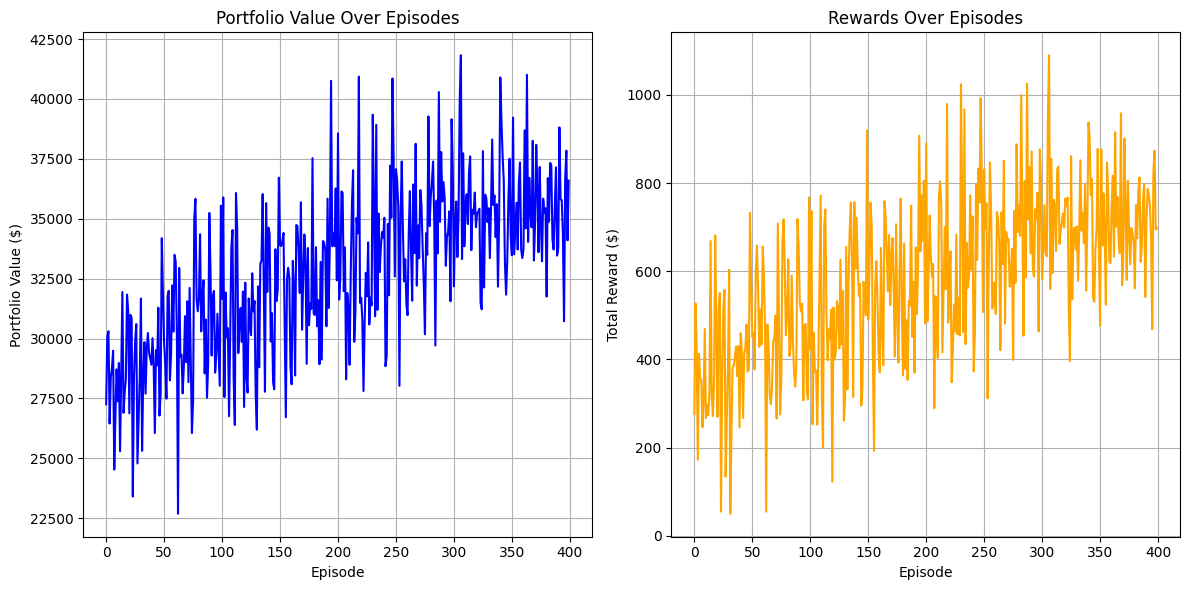


Plotting portfolio value, cash holdings, and individual stock values over the last episode...


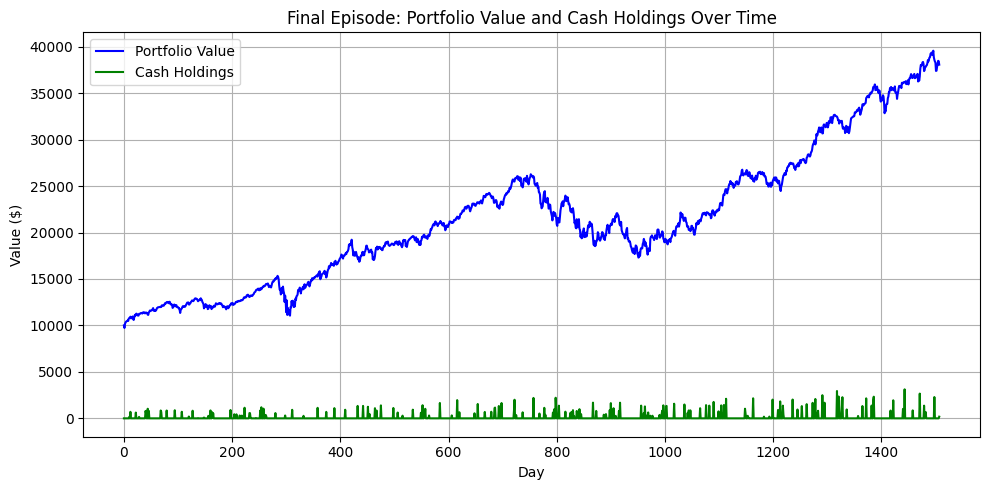

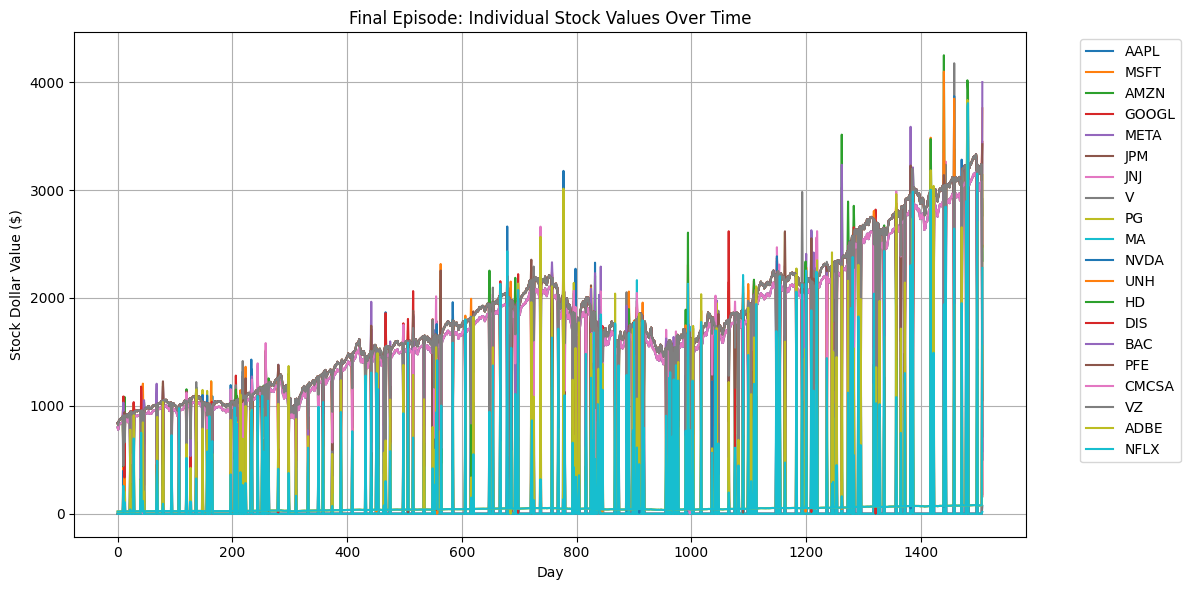

In [16]:
# Plot overall episode performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(portfolio_values, label="Portfolio Value", color="blue")
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(episode_rewards, label="Reward", color="orange")
plt.xlabel("Episode")
plt.ylabel("Total Reward ($)")
plt.title("Rewards Over Episodes")
plt.grid(True)
plt.tight_layout()
plt.show() 

# --------------------------
# Plot daily performance of final episode with Cash Graph and individual Stock Graphs
# --------------------------
print("\nPlotting portfolio value, cash holdings, and individual stock values over the last episode...")

daily_values = []        # total portfolio value (cash + stock values)
daily_cash = []          # cash-only values
daily_stock_values = [[] for _ in range(env.num_stocks)]  # one list per stock

state = env.reset()
done = False

while not done:
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    current_prices = env.stock_prices[env.current_step - 1]
    
    # Calculate total portfolio value for the day.
    portfolio_value = env.cash + np.sum(env.holdings * current_prices)
    daily_values.append(portfolio_value)
    
    # Record cash holdings.
    daily_cash.append(env.cash)
    
    # Record each stock's current dollar value (shares * price).
    for i in range(env.num_stocks):
        stock_value = env.holdings[i] * current_prices[i]
        daily_stock_values[i].append(stock_value)

# Plot portfolio value and cash holdings on the same graph.
plt.figure(figsize=(10, 5))
plt.plot(daily_values, label="Portfolio Value", color="blue")
plt.plot(daily_cash, label="Cash Holdings", color="green")
plt.xlabel("Day")
plt.ylabel("Value ($)")
plt.title("Final Episode: Portfolio Value and Cash Holdings Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figure(figsize=(12, 6))
for i in range(env.num_stocks):
        plt.plot(daily_stock_values[i], label=f"{tickers[i]}")
plt.xlabel("Day")
plt.ylabel("Stock Dollar Value ($)")
plt.title("Final Episode: Individual Stock Values Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


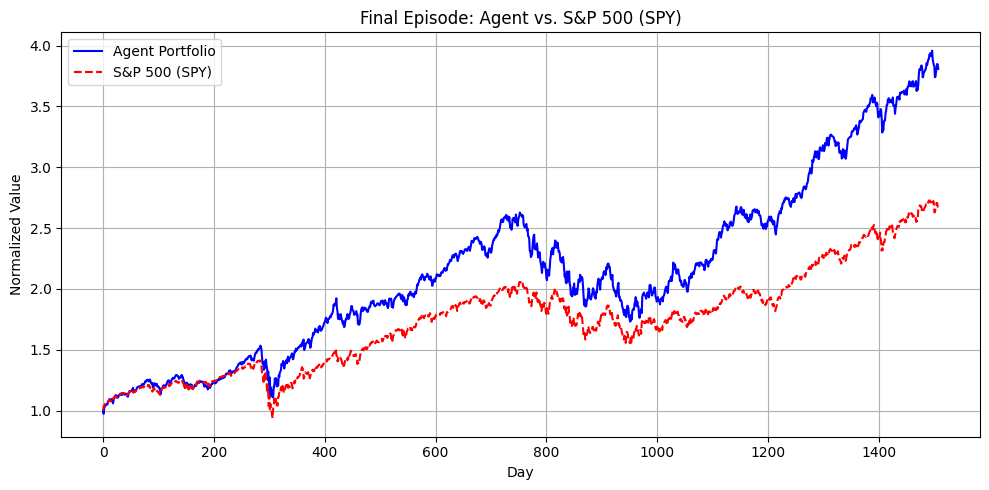

In [17]:
import yfinance as yf

# Get S&P 500 proxy (e.g., SPY ETF) data over the final episode period.
spy_data = yf.download("SPY", start=start, end=end)["Close"].ffill().bfill().values

# Get only the portion of SPY matching the length of your final episode.
# (assuming one trading day per step)
spy_final_episode = spy_data[-len(daily_values):]

# Normalize both to the same starting value for fair comparison
portfolio_base = daily_values[0]
spy_base = spy_final_episode[0]

normalized_portfolio = [v / portfolio_base for v in daily_values]
normalized_spy = [v / spy_base for v in spy_final_episode]

# Plot normalized values
plt.figure(figsize=(10, 5))
plt.plot(normalized_portfolio, label="Agent Portfolio", color="blue")
plt.plot(normalized_spy, label="S&P 500 (SPY)", color="red", linestyle="--")
plt.xlabel("Day")
plt.ylabel("Normalized Value")
plt.title("Final Episode: Agent vs. S&P 500 (SPY)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
